In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from matplotlib.colors import Normalize

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# To Do
* Put GTEx demo spreadsheet into data
* Put GTEx expression spreadsheet (OR LINK) into data
* Put GTEx demo 2 spreadsheet into data
* Put GTEx exclusion spreadsheet into data
* Put GTEx gene spreadsheet into data
* Link "comps" df path to path generated from previous notebook
* Change all the spreadsheet paths
* Add script to prep GTEx data
* Add instructions about the spreadsheet
* Add information about missing Age

# Instructions

In order to run this notebook, you will need to do the following steps:

1) Download the following (version 8) GTEx data from https://gtexportal.org/home/datasets:
* GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt
* GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt
* GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz

Unzip and move into `./data/`

2) Preprocess the data. To do so, run the R script found in `code/GTEx_v8_process.R`. Note that you will first need to ensure several packages and their dependencies are installed: WGCNA, SNFtool, flashClust, CePa, plyr. ***IMPORTANT! This script has not been successfully run on R version 4.x. Please us version 3.x***

***NOTE*** The publicly available GTEx data has binned ages, rather than true ages. For the manuscript, we used "Protected Data" which has the true ages of donors. Therefore, this is perhaps the only manuscript analysis that you will not be able to run yourself with online data. We will include the exact code we ran, and you can substitute our (true) age variable with the binned age variable. But note there will be differences in the results.

# Prep data

In [2]:
df = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_brain_norm_noregress_meta.csv')

In [4]:
# edit this 
df = pandas.read_csv('data/GTEx_brain_norm_noregress_meta.csv')

In [3]:
meta = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/GTEx/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt',
                      sep='\t')

In [5]:
meta = pandas.read_csv('data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt',
                      sep='\t')
meta.shape

Note that here I am getting the true age information from an internal spreadsheet. You will skip this step (unless you have access to the GTEx Protect Data, in which case you may change the path below so it points to your own spreadsheet

In [10]:
# bwdf = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_meta_forJake.csv')
# bwcols = ['AGE']
# df.loc[:,'merger'] = ['%s_%s'%(df.loc[x,'SUBJID'],
#                                df.loc[x,'SMTSD']) for x in df.index]
# bwdf.loc[:,'merger'] = ['%s_%s'%(bwdf.loc[x,'SUBJID'],
#                                bwdf.loc[x,'SMTSD']) for x in bwdf.index]
# jnk = pandas.DataFrame(df,copy=True)
# jnk.loc[:,'old_ind'] = jnk.index.values
# jnk.index = jnk.merger.values
# bwdf.index = bwdf.merger.values
# shared = list(set(bwdf.index) & set(jnk.index))
# for col in bwcols:
#     jnk.loc[shared,col] = bwdf.loc[shared,col].values
#     df.loc[:,col] = jnk.loc[:,col].values

In [6]:
# number of samples
len(df.SUBJID.unique())

376

We also want to make sure that our results aren't driven by individuals with brain diseases. Another recent paper (10.1038/s41593-021-00887-5) recommended an extreme processing stream for the GTEx that, among other rather heavy-handed steps, excluded all individuals who died of/with brain disease. 

Attached is a spreadsheet of GTEx donors remaining after this preprocessing was done. By cross-referencing our spreadsheet (with everyone) with this list of donors (without individuals with brain disease), we can ID who is who

In [4]:
excludf = pandas.read_csv('data/GTEx_healthy.csv',index_col=0)
excludf.loc[:,'Healthy'] = [x.replace('.','-') for x in excludf.Healthy.values]
dx_exclude = list(set(df.SUBJID.values) - set(excludf.Healthy.values))
df.loc[df.SUBJID.isin(dx_exclude),'Excl_Dx'] = 1
df.loc[df.Excl_Dx!=1,'Excl_Dx'] = 0

In [5]:
len(dx_exclude)

151

Note, to run the next line, you will have needed to run the GTEx processing script first (see instructions above).

In [6]:
exp = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/GTEx_brain_norm_noregress.csv')

In [10]:
# load processed expression data 
exp = pandas.read_csv('data/GTEx_brain_norm_noregress.csv')

In [11]:
exp.shape

(15758, 2484)

In [7]:
exp.columns = ['ENSGID'] + exp.columns[1:].tolist()

In [8]:
# spreadsheet to map gene symbol (Allen) to ensemble gene ID (GTEx)
genes = pandas.read_csv('data/gene_info.csv')
genes.head()

,hgnc_symbol,ensembl_gene_id,chromosome_name,start_position,end_position,entrezgene_id
0,FGR,ENSG00000000938,1,27612064,27635185,2268.0
1,STPG1,ENSG00000001460,1,24356999,24416934,90529.0
2,NIPAL3,ENSG00000001461,1,24415802,24472976,57185.0
3,AK2,ENSG00000004455,1,33007940,33080996,204.0
4,KDM1A,ENSG00000004487,1,23019443,23083689,23028.0


# Whole dataset congruence

Here, we will match the GTEx genes with the Allen genes in order to derive PLS components for GTEx samples

In [9]:
gdict = dict(zip(genes.ensembl_gene_id.values,
                genes.hgnc_symbol.values))
gmatch = [np.nan if x not in gdict.keys() else \
          gdict[x] for x in exp.ENSGID.values]
exp.loc[:,'gene_symbol'] = gmatch
exp.dropna(inplace=True)

In [10]:
# NOTE: This spreadsheet was generated from the ModelExploration notebook 
comps = pandas.read_csv('tables/all_comps_ROTATION.csv',index_col = 0)
comps.head()

,gene_symbol,gene_name,C1,C2,C3,C1_genelist,C2_genelist,C3_genelist
0,A1BG,alpha-1-B glycoprotein,0.002967,0.001055,-0.005412,0.0,0.0,0.0
1,A1BG-AS1,NaN,0.001287,-0.001796,0.006987,0.0,0.0,0.0
2,A2M,alpha-2-macroglobulin,0.003203,0.003630,0.000001,0.0,0.0,0.0
3,A2ML1,alpha-2-macroglobulin-like 1,-0.000960,-0.003713,-0.009880,0.0,0.0,0.0
4,A3GALT2,NaN,-0.002451,0.001712,0.003116,0.0,0.0,0.0


#### Match genes

In [11]:
shared_genes = list(set(comps.gene_symbol) & set(exp.gene_symbol))
len(shared_genes)

12647

In [12]:
# Harmonizing expression data with genes shared between both datasets
shared_genes = list(set(comps.gene_symbol) & set(exp.gene_symbol))
matched_comps = pandas.DataFrame(comps[comps.gene_symbol.isin(shared_genes)],
                                 copy=True)
exp = pandas.DataFrame(exp[exp.gene_symbol.isin(shared_genes)],
                                copy=True)

In [13]:
# saving the index for a moment
egenes = exp.gene_symbol.values

Are we harmonized?

In [19]:
exp.shape

(12647, 2485)

In [20]:
matched_comps.shape

(12647, 8)

Yep!

#### regress covariates

Here we are going to regress out the first five "Sequence PCs" from the data. These are PCs derived from confounding covariates (see processing script). ***Note:*** This took a few minutes on my computer
 

In [23]:
# Make empty dataframe
nexp = np.zeros_like(exp.iloc[:,1:-1].values)
# get small table with only relevant covariates
dat = pandas.DataFrame(df[df.columns[8:13]],copy=True)

# regress covariates
count = 0
# for each gene
for i,row in exp.iterrows():
    # fit model regressing the PCs
    dat.loc[:,'exp'] = row.values[1:-1].astype(float)
    mod = smf.ols('exp ~ SeqPC1 + SeqPC2 + SeqPC3 + SeqPC4 + SeqPC5',
                  data=dat).fit()
    # save residuals
    nexp[count,:] = mod.resid.values
    # keep track
    if count%100==0:
        print('finished %s of %s'%(count+1,len(nexp)))
    count+=1

finished 1 of 12647
finished 101 of 12647
finished 201 of 12647
finished 301 of 12647
finished 401 of 12647
finished 501 of 12647
finished 601 of 12647
finished 701 of 12647
finished 801 of 12647
finished 901 of 12647
finished 1001 of 12647
finished 1101 of 12647
finished 1201 of 12647
finished 1301 of 12647
finished 1401 of 12647
finished 1501 of 12647
finished 1601 of 12647
finished 1701 of 12647
finished 1801 of 12647
finished 1901 of 12647
finished 2001 of 12647
finished 2101 of 12647
finished 2201 of 12647
finished 2301 of 12647
finished 2401 of 12647
finished 2501 of 12647
finished 2601 of 12647
finished 2701 of 12647
finished 2801 of 12647
finished 2901 of 12647
finished 3001 of 12647
finished 3101 of 12647
finished 3201 of 12647
finished 3301 of 12647
finished 3401 of 12647
finished 3501 of 12647
finished 3601 of 12647
finished 3701 of 12647
finished 3801 of 12647
finished 3901 of 12647
finished 4001 of 12647
finished 4101 of 12647
finished 4201 of 12647
finished 4301 of 12647


In [24]:
# update the expression dataset with the residuals
exp = pandas.DataFrame(nexp,index=exp.index,columns=exp.columns[1:-1])

In [25]:
exp.loc[:,'gene_symbol'] = egenes

In [26]:
exp.sort_values('gene_symbol',inplace=True)

In [43]:
# You might want to save this so you dont have to run the regression again
# exp.to_csv('data/GTex_harmed_GExp.csv')

# Analyses -- replication

The objective here is to see if the PLS Components derived in AHBA "reproduce" in GTEx. 

The way we're doing this is taking the PLS Model trained on Allen data and applying it to the GTEx data. We compare the "predicted" GTEx data based on gene expression to the predicted Allen data by correlating the predicted values of both datasets across regions. The reason this works is because Y is spatial location, and regions are spatially embedded.

So, what we are essentially doing here is just ensuring that the genes expressed in the Allen PLS Components are expressed in a similar regional pattern in GTEx as they are in AHBA. Another way to think about it is we are looking to see how similar the two are datasets with a specific focus on the expression of genes contributing to the AHBA PLS Components. See the XSpecies.ipynb for different null models.

This is an important step because a) we see how robust the regional expression of PLS Components in a separate dataset, and b) it is necessary to show a very high correlation across datasets if we want to look at how the PLS Components vary over age in the GTEx dataset.

In [14]:
## Load the data if it was already saved
#exp = pandas.read_csv('data/GTex_harmed_GExp.csv',index_col=0)

In [15]:
# create dataframe with the important columns
scols = exp.columns[:-1]
pred = pandas.DataFrame()
for i in range(1,4):
    pred.loc[:,'C%s'%i] = np.dot(exp[scols].values.T,
                                 matched_comps['C%s'%i])
pred.loc[:,'sample'] = scols
pred.loc[:,'Region'] = df.loc[:,'SMTSD'].values

In [16]:
# Make a mapping between GTEx brain regions and AHBA divisions
rkey = dict(zip(pred.Region.unique(),
               ['Frontal','Cerebellum','Frontal','Caudate','Accumbens',
               'Putamen','Hypothalamus','Hippocampus','AntCing',
               'Cerebellum','Nigra','Amygdala']))

In [17]:
# add to new dataframe
for i,row in pred.iterrows():
    pred.loc[i,'Div'] = rkey[row['Region']]

In [17]:
# How are we doing
pred.head()

,C1,C2,C3,sample,Region,Div
0,-0.580291,-0.984428,0.771806,GTEX-1117F-3226-SM-5N9CT,Brain - Cortex,Frontal
1,-0.863472,-0.828119,-1.376216,GTEX-111FC-3126-SM-5GZZ2,Brain - Cortex,Frontal
2,1.592599,-0.686705,-0.932791,GTEX-111FC-3326-SM-5GZYV,Brain - Cerebellum,Cerebellum
3,-1.553241,-0.690719,1.748766,GTEX-1128S-2726-SM-5H12C,Brain - Cortex,Frontal
4,1.232131,-1.074944,0.554599,GTEX-1128S-2826-SM-5N9DI,Brain - Cerebellum,Cerebellum


We want to be able to test how robust the reproducibility is to age of the sample (everyone vs only those in the AHBA age range), cognitive status (everyone vs only those w/o brain disorder at death), and the interaction of these features.

So, we'll create separate subsamples that include:
* full -- Everyone
* younger -- everyone <= 60
* ctrl -- all "controls" (weren't excluded by stringent pipeline)
* yctrl -- all "controls" <= 60

In [ ]:
df.SUBJID

In [36]:
len(df[(df.Excl_Dx==0) & (df.AGE<61)].SUBJID.unique())

114

In [18]:
# create these "datasets"
younger = df[df.AGE<61][df.columns[0]].values
cntrl = df[df.Excl_Dx==0][df.columns[0]].values
datasets = {'full': pred.groupby('Div')[['C1','C2','C3']].mean().sort_index(),
            'younger': pred[pred['sample'].isin(younger)
                                 ].groupby('Div')[['C1','C2','C3']].mean().sort_index(),
            'ctrl': pred[pred['sample'].isin(cntrl)
                        ].groupby('Div')[['C1','C2','C3']].mean().sort_index(),
            'yctrl': pred[(pred['sample'].isin(cntrl)) & (pred['sample'].isin(younger))
                        ].groupby('Div')[['C1','C2','C3']].mean().sort_index()
           }
for nm,gtC in datasets.items():
    gtC.loc[:,'GTeX_div'] = gtC.index
    
# show an example
datasets['full']

,C1,C2,C3,GTeX_div
Div,,,,
Accumbens,-0.607787,0.865196,-0.166952,Accumbens
Amygdala,0.596173,-0.036239,-1.664617,Amygdala
AntCing,-1.215077,1.732998,2.045552,AntCing
Caudate,-1.036106,0.258567,-0.452266,Caudate
Cerebellum,1.817767,-0.795887,-0.049884,Cerebellum
Frontal,-1.481004,-0.269829,0.872312,Frontal
Hippocampus,0.550968,-0.252987,-0.781874,Hippocampus
Hypothalamus,0.930752,0.603934,0.536156,Hypothalamus
Nigra,1.412805,-0.340615,-0.240160,Nigra


========== full ==========
r = 0.949, p = 0.0


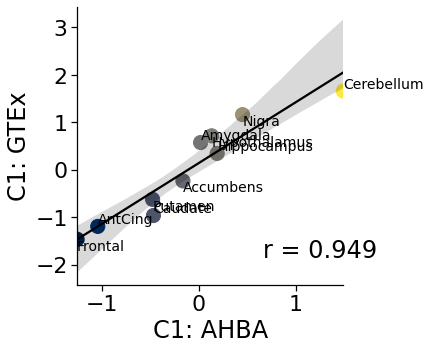

r = 0.823, p = 0.003


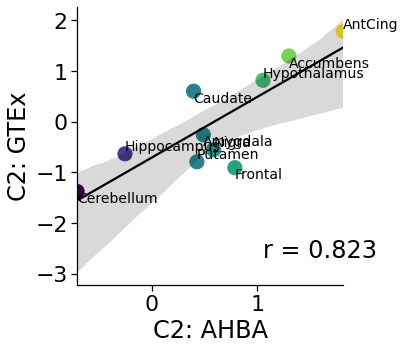

r = 0.476, p = 0.165


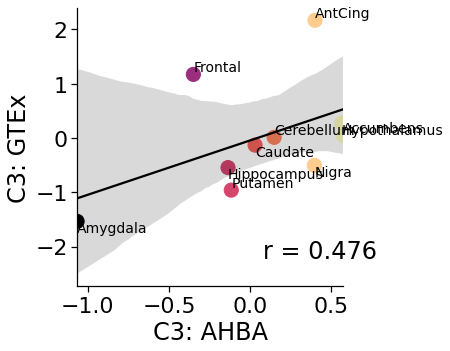

========== younger ==========
r = 0.953, p = 0.0


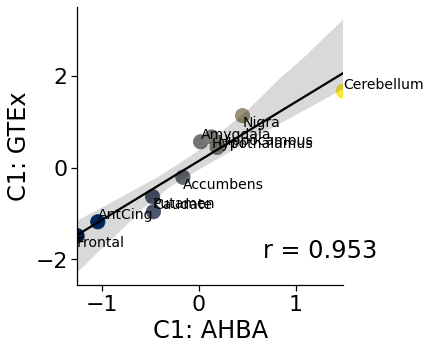

r = 0.842, p = 0.002


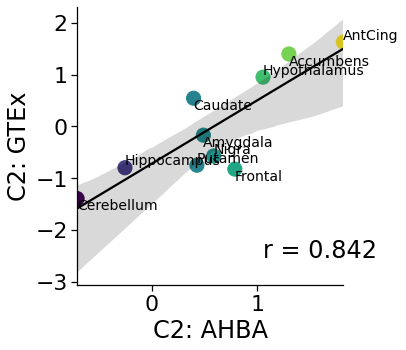

r = 0.482, p = 0.159


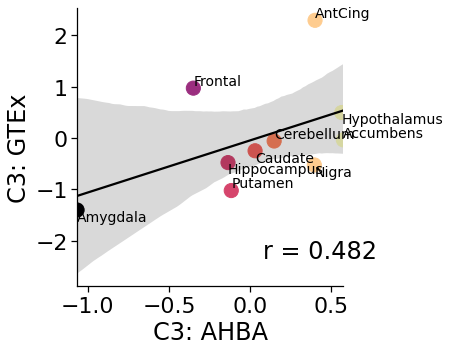

========== ctrl ==========
r = 0.951, p = 0.0


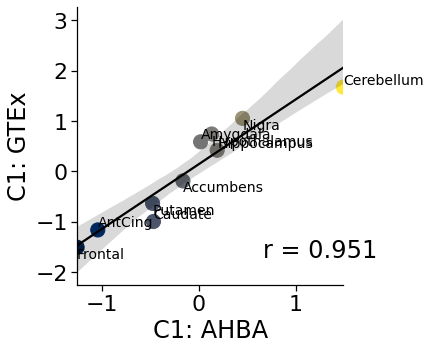

r = 0.838, p = 0.002


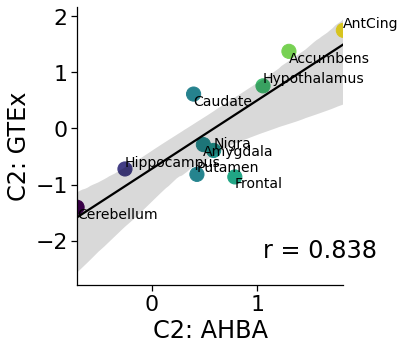

r = 0.505, p = 0.137


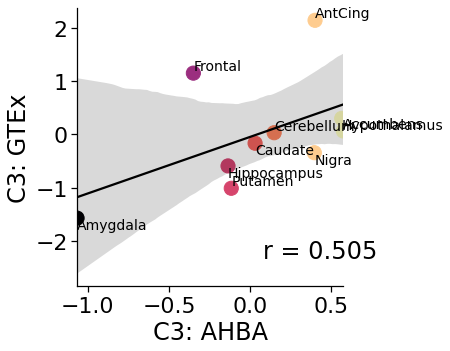

========== yctrl ==========
r = 0.949, p = 0.0


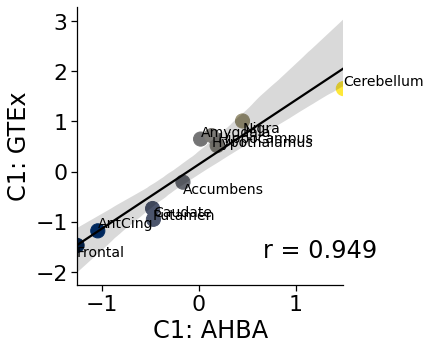

r = 0.864, p = 0.001


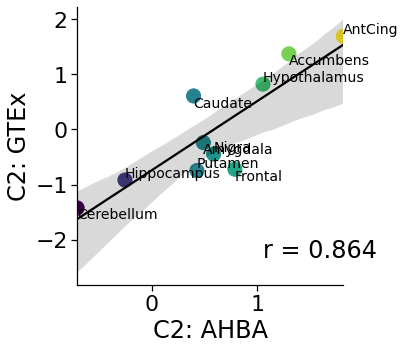

r = 0.496, p = 0.145


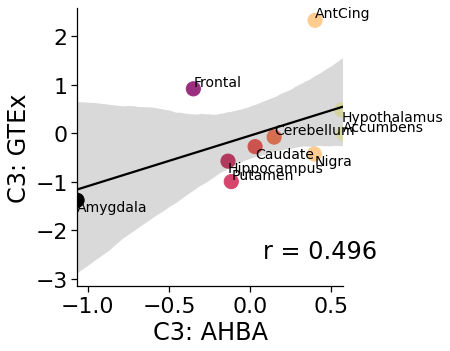

In [111]:
# Run replication analysis and plot

fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/'
sns.set_context('notebook',font_scale=2)

# color scales for lines
pals = ['cividis','viridis','magma'] 

# used to control location of text within plot
# I havent messed with this in awhile as I ended up moving the text
# manually after creating the figure. Like a pleb.
scale = {1:0.02,2:0.015,3:0.008} 

# for each dataset
for nm,gtC in datasets.items(): 
    #if nm != 'full': continue
    print('%s %s %s'%(('='*10),nm,('='*10)))
    # for each PLS component
    for i in range(1,4):
        # standardize data (because no intercept) -- pattern expression
        vals = StandardScaler().fit_transform(gtC.loc[:,'C%s'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
        gtC.loc[:,'zC%s'%i] = vals
        ## !!CHANGE PATH!!##
        # Load Allen component data
        allen = pandas.read_csv('data/GCorr_GTexComp_ABA_C%s_data_ROTATION.csv'%i
                               ).sort_values('GTeX_div')
        allen.index = allen.GTeX_div.values
        allen.drop('Pallidum',axis=0,inplace=True)
        # concatenate GTEx and AHBA data for seaborn plotting
        plotr = pandas.concat([pandas.Series(allen['C%s_Expression'%i
                                                  ].values),
                               pandas.Series(gtC['zC%s'%i].values)],
                              axis=1)
        plotr.columns = ['Allen','GTEx']
        plotr.index = allen.GTeX_div.values

        # add pretty colors (...for continuity!)
        # normalize colorscale of markers by AHBA values
        cmap = sns.color_palette(pals[i-1],as_cmap=True)
        sg = plotr.Allen.values
        scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
        norm = Normalize(vmin=np.min(scaled_sg), 
                                           vmax=np.max(scaled_sg))
        cscale = cmap(norm(scaled_sg))
        
        # plot it
        g = sns.lmplot(x='Allen',y='GTEx',data=plotr,
               scatter_kws={'marker':'o','s':200,'color':cscale},
                      line_kws={'color':'k'})
        # get the inter-dataset correlations
        r,p = stats.pearsonr(plotr.Allen.values,plotr.GTEx.values)
        print('r = %s, p = %s'%(round(r,3),round(p,3)))

        # add text indicating which brain region each marker is
        for it,div in enumerate(plotr.sort_values('Allen').index):
            x = plotr.loc[div,'Allen']
            y = plotr.loc[div,'GTEx']
            dist = len(div)*scale[i]#.02
            if it%2==0:
                plt.text(x, y,div,{'size':14},va='top')
            else:
                plt.text(x, y,div,{'size':14},va='bottom',
                         )
        # decorate
        plt.xlabel('C%s: AHBA'%i)
        plt.ylabel('C%s: GTEx'%i)
        plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
        #plt.xlim(-.45,.45)
        plt.savefig(os.path.join(fig_dir,'GTEx_Repl_%s_C%s_ROTATED.pdf'%(nm,i)), bbox_inches='tight')
        plt.show()

# Add brain divisions

In [35]:
# C1

tele = ['Brain - Cortex','Caudate (basal ganglia)',
       'Brain - Nucleus accumbens (basal ganglia)',
        'Brain - Frontal Cortex (BA9)','Brain - Putamen (basal ganglia)',
        'Brain - Hippocampus','Brain - Anterior cingulate cortex (BA24)',
        'Brain - Amygdala']
dien = ['Brain - Hypothalamus']
met = ['Brain - Substantia nigra']
mes = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere']

divs = [tele, dien, met, mes]
names = ['Tele', 'Dien', 'Met', 'Mes',] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'DevOrigin'] = name

# C2
cortex = ['Brain - Cortex','Brain - Cerebellum',
         'Brain - Cerebellar Hemisphere',
         'Brain - Frontal Cortex (BA9)','Brain - Hippocampus',
         'Brain - Anterior cingulate cortex (BA24)',]
noncortex = ['Caudate (basal ganglia)',
             'Brain - Nucleus accumbens (basal ganglia)',
            'Brain - Putamen (basal ganglia)','Brain - Hypothalamus',
             'Brain - Amygdala','Brain - Substantia nigra']
divs = [cortex,noncortex]
names = ['Cortex','NonCortex'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'Cortex'] = name

# C3
assoc = ['Brain - Cortex','Brain - Frontal Cortex (BA9)',
        'Brain - Anterior cingulate cortex (BA24)']
lbf = ['Brain - Nucleus accumbens (basal ganglia)',
      'Brain - Hippocampus','Brain - Amygdala']
bg = ['Caudate (basal ganglia)','Brain - Putamen (basal ganglia)',
     ]
other = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere',
        'Brain - Hypothalamus','Brain - Substantia nigra']

divs = [assoc,lbf,bg,other]
names = ['Association','Limbic/BF','BasalGanglia','Other'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'CortType'] = name

In [36]:
len(df)

2483

# Widen dataframes for individual analysis

We can apply the same logic above to measure individual correspondence to Allen components. In other words, now that we know the Allen components replicate in GTEx, we can look at replication at an individual level. Since GTEx has a wide age range, we can look to see whether and how the manifestation of these components changes with age

In [46]:
pred.loc[:,'SUBJID'] = df.SUBJID.values

In [47]:
# For each component, make a subject x region matrix
# and keep track of number of valid regions for each subject
gpdfs = {}
for i in range(1,4):
    gpdf = pred[['SUBJID','C%s'%i,'Div']
              ].set_index(['SUBJID'],append=True
                         ).pivot_table(index='SUBJID',
                                       columns='Div',
                                       values='C%s'%i)
    
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [48]:
# an example
print(gpdfs[1].shape)
gpdfs[1].head()

(376, 11)


Div,Accumbens,Amygdala,AntCing,Caudate,Cerebellum,Frontal,Hippocampus,Hypothalamus,Nigra,Putamen,n_valid
SUBJID,,,,,,,,,,,
GTEX-1117F,NaN,NaN,NaN,NaN,NaN,-6.628800,NaN,NaN,NaN,NaN,1.0
GTEX-111FC,NaN,NaN,NaN,NaN,15.515697,-8.025321,NaN,NaN,NaN,NaN,2.0
GTEX-1128S,NaN,NaN,NaN,NaN,10.256824,-14.408146,NaN,NaN,NaN,NaN,2.0
GTEX-117XS,NaN,NaN,NaN,NaN,15.236004,-18.051822,NaN,NaN,NaN,NaN,2.0
GTEX-1192X,-6.19463,NaN,NaN,-7.580589,19.050250,-19.363951,NaN,1.819531,NaN,1.435273,6.0


# Individual congruence

Here, we use similar code above to define the correlation between each subject's regional component expression to the expression of that component in the AHBA. We exclude all individuals with less than 6 valid regions

In [49]:
# for each component
for c in range(1,4):
    cdf = gpdfs[c]
    # load allen regional daata
    # !!CHANGE PATH!!
    allen = pandas.read_csv('data/GCorr_GTexComp_ABA_C%s_data_ROTATION.csv'%c
                           ).sort_values('GTeX_div')
    allen.index = allen.GTeX_div.values
    allen.drop('Pallidum',axis=0,inplace=True)
    avec = allen.loc[cdf.columns[:-1]]
    # for each subjects
    for i,row in cdf.iterrows():
        # build a correlation df
        forcorr = pandas.DataFrame(allen,copy=True)
        # exclude subjects with <6 regions available
        if row['n_valid'] > 5:
            # calculate subject - AHBA correlation
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['C%s_Expression'%c].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['C%s_Expression'%c].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

Now we summarize everything into one convenient dataframe

In [50]:
cols = ['SUBJID', 'RIN', 'BATCH', 'GBATCH', 'AGE', 'SEX',
       'SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5'] #+ bwcols
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = df.groupby('SUBJID')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

Now we save this spreadsheet, because we do all the analysis in the C_BrainSpanValidation notebook

In [51]:
# Save this spreadsheet to open it 
# !!CHANGE PATH!!
subsum.to_csv('data/GTEx_IndivCongruence_ROTATION.csv')

# Redo with proper rotated approach

In [20]:
# Generated in NB1
hbigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
hgdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
hbigdf.index = hgdf.index
hbigdf.drop('well_id',axis=1,inplace=True)

In [21]:
hbigdf = hbigdf[exp.gene_symbol.values]

In [22]:
hbigdf.shape

(3466, 12647)

#### Assess if okay to move forward with this approach

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# recover the PCA results
pcamod = PCA(n_components=100, random_state=123).fit(hbigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(hbigdf),index = hgdf.index)

# test to see performance of model
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pred = cross_val_predict(pls_mod,pca_tfm,full_y,cv=10)
#sns.regplot(pred,full_y)
print('r2_score =',r2_score(full_y,pred))
print('mae =',mean_absolute_error(full_y,pred))

r2_score = 0.5240265538945982
mae = 14.520061622996685


In [23]:
shared = exp.gene_symbol.tolist()

In [24]:
comps.index = comps.gene_symbol.values

In [28]:
for col in ['C1','C2','C3']:
    comps.loc[:,'abs_%s'%col] = abs(comps[col].values)
    comps.sort_values('abs_%s'%col,inplace=True,ascending=False)
    comps.loc[:,'%sind'%col] = range(len(comps))
    
    print('****',col,'****')
    pos = [x for x in comps.sort_values('abs_%s'%col,ascending=True
                                          ).index[:130] if x in shared]
    neg = [x for x in comps.sort_values('abs_%s'%col).index[:130] if x in shared]
    print('%s%% positive genes, %s%% negative genes present'%(round(((len(pos)/130)*100),2),
                                                              round(((len(neg)/130)*100),2)))
    weight_ratio = sum(comps.loc[shared]['abs_%s'%col].values) /\
                   sum(comps['abs_%s'%col].values)
    print('%s%% of weight accounted for \n'%round(weight_ratio*100,2))

**** C1 ****
83.85% positive genes, 83.85% negative genes present
79.06% of weight accounted for 

**** C2 ****
79.23% positive genes, 79.23% negative genes present
80.45% of weight accounted for 

**** C3 ****
79.23% positive genes, 79.23% negative genes present
80.08% of weight accounted for 



In [30]:
# refit PLS with only GTEx genes
from sklearn.cross_decomposition import PLSRegression
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]

pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [39]:
# Apply PCA then PLS transform
hb_pcatfm = pcamod.transform(MinMaxScaler().fit_transform(exp[exp.columns[:-1]]).T)
preds = pls_mod.predict(hb_pcatfm)

In [41]:
pred.loc[:,'predicted_y'] = preds[:,0]
pred.loc[:,'predicted_z'] = preds[:,1]
pred.loc[:,'predicted_x'] = preds[:,2]

In [54]:
Frontal = ['anterior orbital gyrus, left','anterior orbital gyrus, right',
           'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
          'frontal operculum, left','frontal operculum, right',
          'frontal pole, left, inferior aspect','frontal pole, left, medial aspect',
          'frontal pole, left, superior aspect','frontal pole, right, inferior aspect',
          'frontal pole, right, medial aspect','frontal pole, right, superior aspect',
          'gyrus rectus, left','gyrus rectus, right',
          'inferior frontal gyrus, opercular part, left','inferior frontal gyrus, opercular part, right',
          'inferior frontal gyrus, orbital part, left','inferior frontal gyrus, orbital part, right',
          'inferior frontal gyrus, triangular part, left','inferior frontal gyrus, triangular part, right',
          'inferior rostral gyrus, left','inferior rostral gyrus, right',
          'lateral orbital gyrus, left','lateral orbital gyrus, right',
          'medial orbital gyrus, left','medial orbital gyrus, right',
          'middle frontal gyrus, left, inferior bank of gyrus','middle frontal gyrus, left, superior bank of gyrus',
          'middle frontal gyrus, right, inferior bank of gyrus','middle frontal gyrus, right, superior bank of gyrus',
          'posterior orbital gyrus, left','posterior orbital gyrus, right',
          'superior frontal gyrus, left','superior frontal gyrus, left, lateral bank of gyrus',
          'superior frontal gyrus, left, medial bank of gyrus','superior frontal gyrus, right, lateral bank of gyrus',
          'superior frontal gyrus, right, medial bank of gyrus',
          'superior rostral gyrus, left','superior rostral gyrus, right']

Anterior_Cingulate = ['cingulate gyrus, frontal part, left, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, left, superior bank of gyrus',
                     'cingulate gyrus, frontal part, right, inferior bank of gyrus',
                     'cingulate gyrus, frontal part, right, superior bank of gyrus',
                     'paraterminal gyrus, right',
                     'parolfactory gyri, left','parolfactory gyri, right',
                     'subcallosal cingulate gyrus, left','subcallosal cingulate gyrus, right']

Hypothalamus = ['anterior hypothalamic area, left','anterior hypothalamic area, right',
               'arcuate nucleus of the hypothalamus, left','arcuate nucleus of the hypothalamus, right',
               'dorsomedial hypothalamic nucleus, left',
               'lateral hypothalamic area, anterior region, left', 'lateral hypothalamic area, anterior region, right',
               'lateral hypothalamic area, mammillary region, left', 'lateral hypothalamic area, mammillary region, right',
               'lateral hypothalamic area, tuberal region, left',
               'paraventricular nucleus of the hypothalamus, left','paraventricular nucleus of the hypothalamus, right',
               'perifornical nucleus, left',
               'posterior hypothalamic area, left','posterior hypothalamic area, right',
               'preoptic region, left','preoptic region, right',
               'supraoptic nucleus, left','supraoptic nucleus, right',
               'ventromedial hypothalamic nucleus, left','ventromedial hypothalamic nucleus, right',]

DCN = ['dentate nucleus, left',
       'dentate nucleus, right',
       'emboliform nucleus, left',
       'emboliform nucleus, right',
       'fastigial nucleus, left',
       'fastigial nucleus, right',
       'globose nucleus, left',
       'globose nucleus, right']

Cerebellum = [x for x in g2[g2.slab_type=='CB']['structure_name'].unique().tolist() if x not in DCN]


In [55]:
g2=pandas.read_csv('data/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv',
                  index_col=0)
g2.drop(g2.columns[0],axis=1,inplace=True)
g2 = g2.loc[hgdf.index]

gfrontal = Frontal
gAC = Anterior_Cingulate
gCereb = Cerebellum
gHT = Hypothalamus
gCaud = ['body of caudate nucleus, left',
         'body of caudate nucleus, right',
        'head of caudate nucleus, left',
         'head of caudate nucleus, right',
        'tail of caudate nucleus, left',
         'tail of caudate nucleus, right']
gPut = ['putamen, left','putamen, right',]
gGP = ['globus pallidus, external segment, left',
       'globus pallidus, external segment, right',
       'globus pallidus, internal segment, left',
       'globus pallidus, internal segment, right',]
gAmyg = ['basolateral nucleus, left','basolateral nucleus, right',
          'basomedial nucleus, left','basomedial nucleus, right',
          'central nucleus, left','central nucleus, right',
          'cortico-medial group, left','cortico-medial group, right',
        'lateral nucleus, left','lateral nucleus, right']
gHipp = ['CA1 field, left','CA1 field, right',
          'CA2 field, left','CA2 field, right',
          'CA3 field, left','CA3 field, right',
          'CA4 field, left','CA4 field, right',
         'dentate gyrus, left','dentate gyrus, right',
        'subiculum, left','subiculum, right']
sn = ['substantia nigra, pars compacta, left',
      'substantia nigra, pars compacta, right',
      'substantia nigra, pars reticulata, left',
      'substantia nigra, pars reticulata, right']
gNAcc = ['nucleus accumbens, left','nucleus accumbens, right',]

divs = [gfrontal, gAC, gCereb, gHT, gCaud, gPut, gGP, gAmyg, 
        gHipp,sn,gNAcc]
names = ['Frontal', 'AntCing', 'Cerebellum', 'Hypothalamus', 
         'Caudate','Putamen','Pallidum','Amygdala','Hippocampus',
        'Nigra','Accumbens']
brain_division = dict(zip(names,divs))

for name, div in brain_division.items():
    g2.loc[g2[g2.structure_name.isin(div)].index,'GTeX_div'] = name

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.7907799958308416 0.006456193627383555


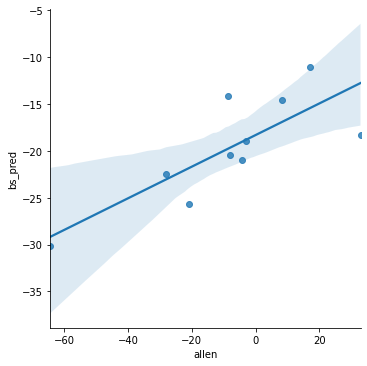

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.7589536857021311 0.010912000810811064


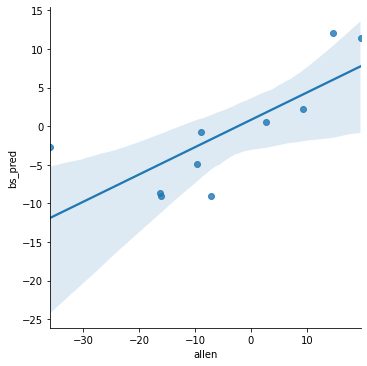

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.754977692738316 0.011589180364100676


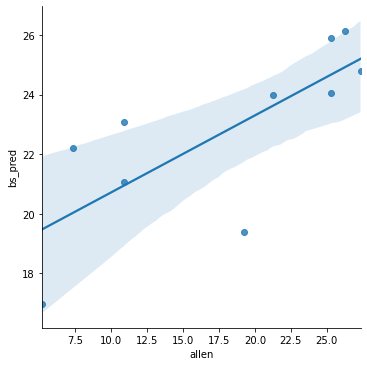

In [59]:
goodregs = set(pred.Div.unique()) & set(g2.GTeX_div.unique())
abay = g2[g2.GTeX_div.isin(goodregs)].groupby('GTeX_div')['mni_nlin_y'].mean()
bsy = pred[pred.Div.isin(goodregs)].groupby('Div')['predicted_y'].mean()
plotr=pandas.concat([abay,bsy],axis=1)
plotr.columns = ['allen','bs_pred']
plotr.loc[:,'region'] = goodregs
sns.lmplot('allen','bs_pred',data=plotr,)
r,p = stats.pearsonr(abay,bsy)
print(r,p)
plt.show()

abaz = g2[g2.GTeX_div.isin(goodregs)].groupby('GTeX_div')['mni_nlin_z'].mean()
bsz = pred[pred.Div.isin(goodregs)].groupby('Div')['predicted_z'].mean()
plotr=pandas.concat([abaz,bsz],axis=1)
plotr.columns = ['allen','bs_pred']
plotr.loc[:,'region'] = goodregs
sns.lmplot('allen','bs_pred',data=plotr,)
r,p = stats.pearsonr(abaz,bsz)
print(r,p)
plt.show()

abax = g2[g2.GTeX_div.isin(goodregs)].groupby('GTeX_div')['abs_mni_nlin_x'].mean()
bsx = pred[pred.Div.isin(goodregs)].groupby('Div')['predicted_x'].mean()
plotr=pandas.concat([abax,bsx],axis=1)
plotr.columns = ['allen','bs_pred']
plotr.loc[:,'region'] = goodregs
sns.lmplot('allen','bs_pred',data=plotr,)
r,p = stats.pearsonr(abax,bsx)
print(r,p)
plt.show()

In [ ]:
cols = ['SUBJID', 'RIN', 'BATCH', 'GBATCH', 'AGE', 'SEX',
       'SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5']
for col in cols:
    pred.loc[:,col] = df[col].values

In [141]:
# create individual dfs for each dimension
dims = dict(zip(['predicted_y','predicted_z','predicted_x'],
               ['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']))
gpdfs = {}
for bdim,adim in dims.items():
    gpdf = pred[['SUBJID',bdim,'Div']
                  ].set_index(['SUBJID'],append=True
                             ).pivot_table(index='SUBJID',
                                           columns='Div',
                                           values=bdim)
    #gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({bdim: gpdf})

In [142]:
# now we'll create similarity calculations for each subject, for each component.
# we'll only use subjects that have data for 6+ brain regions


# for each dimension
for bdim,adim in dims.items():
    # prep data
    cdf = gpdfs[bdim]
    aba = pandas.DataFrame(g2[g2.GTeX_div.isin(goodregs)].groupby('GTeX_div')[adim].mean())
    aba.columns = ['ABA_mean',]
    aba = aba.loc[cdf.columns[:-2]]
    # for each subject
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-2]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            cdf.loc[i,'%s_r'%bdim] = r
            cdf.loc[i,'%s_rho'%bdim] = rho

In [105]:
subsu,

(376, 13)

In [143]:
# build a summary dataframe at the indexed by subjects

cols = ['SUBJID', 'RIN', 'BATCH', 'GBATCH', 'AGE', 'SEX',
       'SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5']
subsum = pandas.DataFrame(gpdfs[bdim].index)
for col in cols:
    subsum.loc[:,col] = pred.groupby('SUBJID')[col].first().values
for bdim,adim in dims.items():
    subsum.loc[:,'%s_r'%bdim] = gpdfs[bdim].loc[:,'%s_r'%bdim].values
    subsum.loc[:,'%s_rho'%bdim] = gpdfs[bdim].loc[:,'%s_rho'%bdim].values
    subsum.loc[:,'n_valid'] = gpdfs[bdim].loc[:,'n_valid'].values

In [144]:
subsum.loc[:,'mean_x_dimensions_r'] = subsum[['predicted_y_r','predicted_z_r','predicted_x_r']].mean(1).values

In [145]:
subsum.loc[:,'age_in_months'] = (subsum.loc[:,'AGE'] * 12)+9
subsum.loc[:,'age_in_weeks'] = (subsum.loc[:,'AGE'] * 52)+40

In [146]:
subsum.loc[:,'log_age_weeks'] = np.log(subsum.loc[:,'age_in_weeks'].values)


r=-0.122, p=0.0757


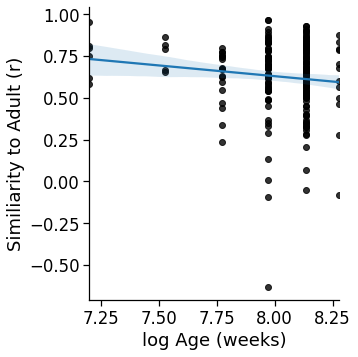

r=0.006, p=0.9311


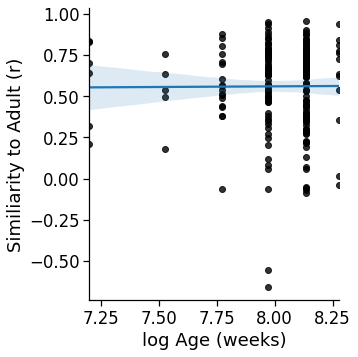

r=-0.021, p=0.7612


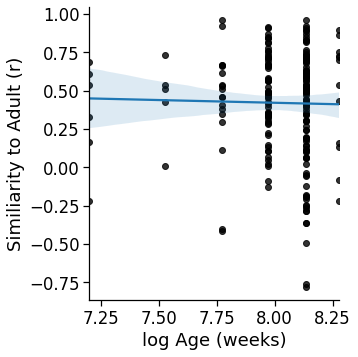

In [149]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 
pals = ['cividis','viridis','magma']

sns.set_context('notebook',font_scale=1.5)
# for each component
for bdim,adim in dims.items():
    # plot
    g=sns.lmplot(x='log_age_weeks',y='%s_r'%bdim,
                lowess=False,
                 scatter_kws={'color':'k'},
               data=subsum)
    plotr = pandas.DataFrame(subsum[['%s_r'%bdim,'log_age_weeks']],
                            copy=True).dropna()
    # get stats
    r,p=stats.pearsonr(plotr['%s_r'%bdim].values,
                      plotr.log_age_weeks.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
#     # make line purty
#     x, y = g.ax.get_lines()[0].get_data()
#     segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
#     norm = plt.Normalize(x.min(), x.max())
#     lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
#     lc.set_array(x[:-1])
#     lc.set_linewidth(2)
#     g.ax.get_lines()[0].remove()
#     line = g.ax.add_collection(lc)
#     plt.setp(line,linewidth=5)
    
#     # decorate so age stage is indicated
#     for stage in gdf.Age_Stage.unique():
#         levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
#         xmin = np.min(levels)
#         xmax = np.max(levels)
#         plt.plot([xmin,xmax],[1.1,1.1],lw=5)
#         #loc = xmin + (xmax-xmin)*.5
#         plt.text(xmin,1.1,stage,fontsize=16,ha='left',
#                  va='bottom',rotation=30)
    
    # further decorate
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)',)#fontsize=30)
    #plt.ylim(-0.28,1.1)
    ymin = subsum['%s_r'%bdim].min() - 0.1
    #plt.axvline(np.log(40),ymax=0.95,c='k')
    #plt.text(np.log(40)+0.1,0.9,'birth')
    #plt.savefig(os.path.join(fig_dir,'BrSp_CompR_C%s.pdf'%c), bbox_inches='tight')
    plt.show()
    



r=-0.06, p=0.3883


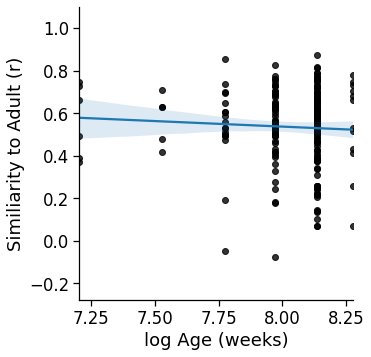

In [151]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 
pals = ['cividis','viridis','magma']

sns.set_context('notebook',font_scale=1.5)
# for each component
for bdim in ['mean_x_dimensions']:
    # plot
    g=sns.lmplot(x='log_age_weeks',y='%s_r'%bdim,
                lowess=False,
                 scatter_kws={'color':'k'},
               data=subsum)
    plotr = pandas.DataFrame(subsum[['%s_r'%bdim,'log_age_weeks']],
                            copy=True).dropna()
    # get stats
    r,p=stats.pearsonr(plotr['%s_r'%bdim].values,
                      plotr.log_age_weeks.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    
#     # make line purty
#     x, y = g.ax.get_lines()[0].get_data()
#     segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
#     norm = plt.Normalize(x.min(), x.max())
#     lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
#     lc.set_array(x[:-1])
#     lc.set_linewidth(2)
#     g.ax.get_lines()[0].remove()
#     line = g.ax.add_collection(lc)
#     plt.setp(line,linewidth=5)
    
#     # decorate so age stage is indicated
#     for stage in gdf.Age_Stage.unique():
#         levels = gdf[gdf.Age_Stage==stage]['log_age_weeks'].values
#         xmin = np.min(levels)
#         xmax = np.max(levels)
#         plt.plot([xmin,xmax],[1.1,1.1],lw=5)
#         #loc = xmin + (xmax-xmin)*.5
#         plt.text(xmin,1.1,stage,fontsize=16,ha='left',
#                  va='bottom',rotation=30)
    
    # further decorate
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)',)#fontsize=30)
    plt.ylim(-0.28,1.1)
    ymin = subsum['%s_r'%bdim].min() - 0.1
    #plt.axvline(np.log(40),ymax=0.95,c='k')
    #plt.text(np.log(40)+0.1,0.9,'birth')
    #plt.savefig(os.path.join(fig_dir,'BrSp_CompR_C%s.pdf'%c), bbox_inches='tight')
    plt.show()
    


# Predicted X!

In [91]:
pls_mod.x_rotations_.shape

(100, 3)

In [94]:
# deal with reversed component
multiplier = np.array([np.ones(pls_mod.x_rotations_.shape[0]),
          np.ones(pls_mod.x_rotations_.shape[0]),
          np.ones(pls_mod.x_rotations_.shape[0])]).T
multiplier[:,2] = -1

pls_mod.x_rotations_ *= multiplier

In [95]:
# normalize by young controls
n_comps=3
mmmod = MinMaxScaler().fit(exp[list(set(cntrl) & set(younger))].T)
hb_pcatfm = pcamod.transform(mmmod.transform(exp[exp.columns[:-1]].T))
xtfm = pls_mod.transform(hb_pcatfm)
for c in range(n_comps):
    pred.loc[:,'C%s'%(c+1)] = xtfm[:,c]

In [61]:
# just go for it 
n_comps=3
hb_pcatfm = pcamod.transform(MinMaxScaler().fit_transform(exp[exp.columns[:-1]]).T)
xtfm = pls_mod.transform(hb_pcatfm)
for c in range(n_comps):
    pred.loc[:,'C%s'%(c+1)] = xtfm[:,c]

========== full ==========
r = 0.949, p = 0.0


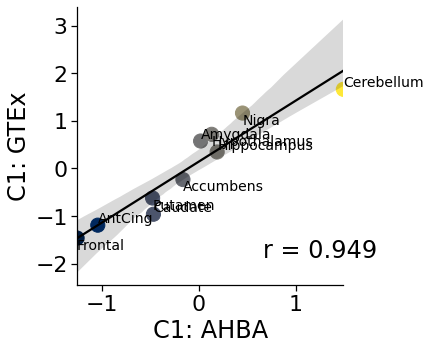

r = 0.823, p = 0.003


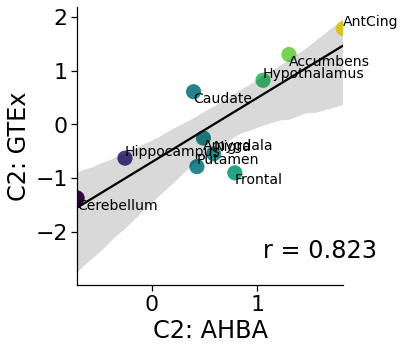

r = 0.476, p = 0.165


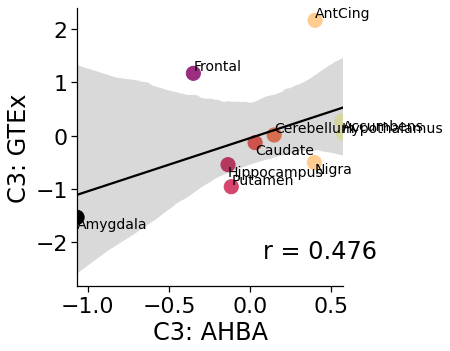

========== younger ==========
r = 0.953, p = 0.0


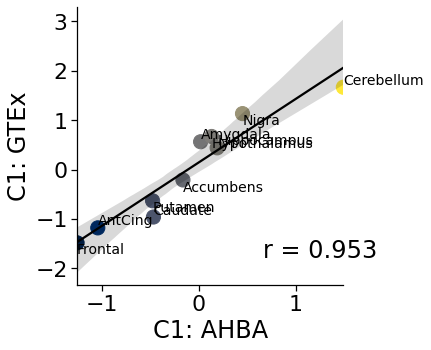

r = 0.842, p = 0.002


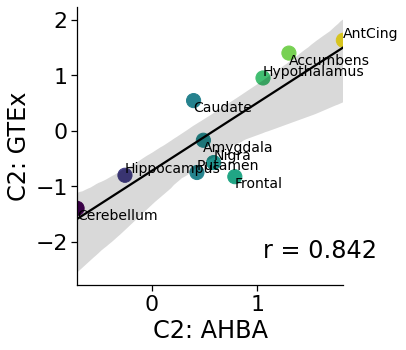

r = 0.482, p = 0.159


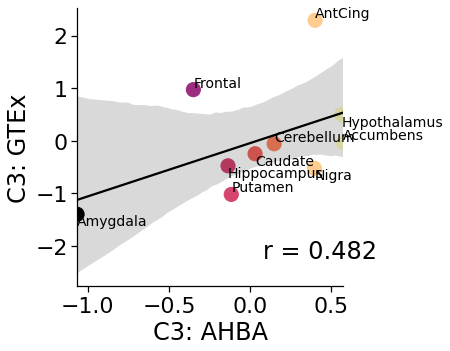

========== ctrl ==========
r = 0.951, p = 0.0


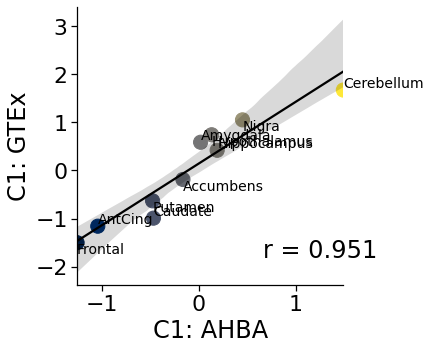

r = 0.838, p = 0.002


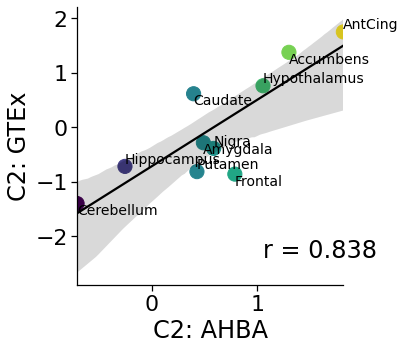

r = 0.505, p = 0.137


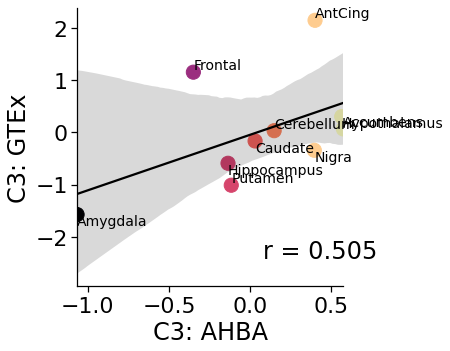

========== yctrl ==========
r = 0.949, p = 0.0


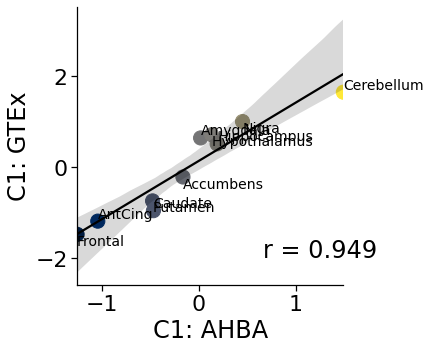

r = 0.864, p = 0.001


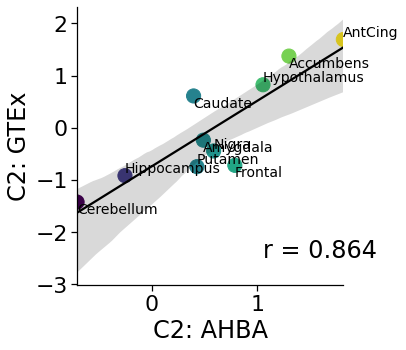

r = 0.496, p = 0.145


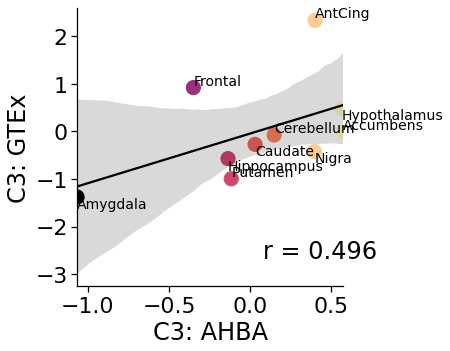

In [98]:
# Run replication analysis and plot

fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/'
sns.set_context('notebook',font_scale=2)

# color scales for lines
pals = ['cividis','viridis','magma'] 

# used to control location of text within plot
# I havent messed with this in awhile as I ended up moving the text
# manually after creating the figure. Like a pleb.
scale = {1:0.02,2:0.015,3:0.008} 

# for each dataset
for nm,gtC in datasets.items(): 
    #if nm != 'full': continue
    print('%s %s %s'%(('='*10),nm,('='*10)))
    # for each PLS component
    for i in range(1,4):
        # standardize data (because no intercept) -- pattern expression
        vals = StandardScaler().fit_transform(gtC.loc[:,'C%s'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
        gtC.loc[:,'zC%s'%i] = vals
        ## !!CHANGE PATH!!##
        # Load Allen component data
        allen = pandas.read_csv('data/GCorr_GTexComp_ABA_C%s_data_ROTATION.csv'%i
                               ).sort_values('GTeX_div')
        allen.index = allen.GTeX_div.values
        allen.drop('Pallidum',axis=0,inplace=True)
        # concatenate GTEx and AHBA data for seaborn plotting
        plotr = pandas.concat([pandas.Series(allen['C%s_Expression'%i
                                                  ].values),
                               pandas.Series(gtC['zC%s'%i].values)],
                              axis=1)
        plotr.columns = ['Allen','GTEx']
        plotr.index = allen.GTeX_div.values

        # add pretty colors (...for continuity!)
        # normalize colorscale of markers by AHBA values
        cmap = sns.color_palette(pals[i-1],as_cmap=True)
        sg = plotr.Allen.values
        scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
        norm = Normalize(vmin=np.min(scaled_sg), 
                                           vmax=np.max(scaled_sg))
        cscale = cmap(norm(scaled_sg))
        
        # plot it
        g = sns.lmplot(x='Allen',y='GTEx',data=plotr,
               scatter_kws={'marker':'o','s':200,'color':cscale},
                      line_kws={'color':'k'})
        # get the inter-dataset correlations
        r,p = stats.pearsonr(plotr.Allen.values,plotr.GTEx.values)
        print('r = %s, p = %s'%(round(r,3),round(p,3)))

        # add text indicating which brain region each marker is
        for it,div in enumerate(plotr.sort_values('Allen').index):
            x = plotr.loc[div,'Allen']
            y = plotr.loc[div,'GTEx']
            dist = len(div)*scale[i]#.02
            if it%2==0:
                plt.text(x, y,div,{'size':14},va='top')
            else:
                plt.text(x, y,div,{'size':14},va='bottom',
                         )
        # decorate
        plt.xlabel('C%s: AHBA'%i)
        plt.ylabel('C%s: GTEx'%i)
        plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
        #plt.xlim(-.45,.45)
        #plt.savefig(os.path.join(fig_dir,'GTEx_Repl_%s_C%s_ROTATED.pdf'%(nm,i)), bbox_inches='tight')
        plt.show()

# Add brain divisions

In [99]:
# C1

tele = ['Brain - Cortex','Caudate (basal ganglia)',
       'Brain - Nucleus accumbens (basal ganglia)',
        'Brain - Frontal Cortex (BA9)','Brain - Putamen (basal ganglia)',
        'Brain - Hippocampus','Brain - Anterior cingulate cortex (BA24)',
        'Brain - Amygdala']
dien = ['Brain - Hypothalamus']
met = ['Brain - Substantia nigra']
mes = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere']

divs = [tele, dien, met, mes]
names = ['Tele', 'Dien', 'Met', 'Mes',] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'DevOrigin'] = name

# C2
cortex = ['Brain - Cortex','Brain - Cerebellum',
         'Brain - Cerebellar Hemisphere',
         'Brain - Frontal Cortex (BA9)','Brain - Hippocampus',
         'Brain - Anterior cingulate cortex (BA24)',]
noncortex = ['Caudate (basal ganglia)',
             'Brain - Nucleus accumbens (basal ganglia)',
            'Brain - Putamen (basal ganglia)','Brain - Hypothalamus',
             'Brain - Amygdala','Brain - Substantia nigra']
divs = [cortex,noncortex]
names = ['Cortex','NonCortex'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'Cortex'] = name

# C3
assoc = ['Brain - Cortex','Brain - Frontal Cortex (BA9)',
        'Brain - Anterior cingulate cortex (BA24)']
lbf = ['Brain - Nucleus accumbens (basal ganglia)',
      'Brain - Hippocampus','Brain - Amygdala']
bg = ['Caudate (basal ganglia)','Brain - Putamen (basal ganglia)',
     ]
other = ['Brain - Cerebellum','Brain - Cerebellar Hemisphere',
        'Brain - Hypothalamus','Brain - Substantia nigra']

divs = [assoc,lbf,bg,other]
names = ['Association','Limbic/BF','BasalGanglia','Other'] 
brain_division = dict(zip(names,divs))
for name, div in brain_division.items():
    pred.loc[pred[pred.Region.isin(div)].index,'CortType'] = name

# Widen dataframes for individual analysis

We can apply the same logic above to measure individual correspondence to Allen components. In other words, now that we know the Allen components replicate in GTEx, we can look at replication at an individual level. Since GTEx has a wide age range, we can look to see whether and how the manifestation of these components changes with age

In [100]:
pred.loc[:,'SUBJID'] = df.SUBJID.values

In [101]:
# For each component, make a subject x region matrix
# and keep track of number of valid regions for each subject
gpdfs = {}
for i in range(1,4):
    gpdf = pred[['SUBJID','C%s'%i,'Div']
              ].set_index(['SUBJID'],append=True
                         ).pivot_table(index='SUBJID',
                                       columns='Div',
                                       values='C%s'%i)
    
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [102]:
# an example
print(gpdfs[1].shape)
gpdfs[1].head()

(376, 11)


Div,Accumbens,Amygdala,AntCing,Caudate,Cerebellum,Frontal,Hippocampus,Hypothalamus,Nigra,Putamen,n_valid
SUBJID,,,,,,,,,,,
GTEX-1117F,NaN,NaN,NaN,NaN,NaN,-0.008269,NaN,NaN,NaN,NaN,1.0
GTEX-111FC,NaN,NaN,NaN,NaN,0.430501,-0.252980,NaN,NaN,NaN,NaN,2.0
GTEX-1128S,NaN,NaN,NaN,NaN,0.305905,-0.402159,NaN,NaN,NaN,NaN,2.0
GTEX-117XS,NaN,NaN,NaN,NaN,0.407761,-0.269845,NaN,NaN,NaN,NaN,2.0
GTEX-1192X,-0.06743,NaN,NaN,-0.349349,0.676380,-0.516985,NaN,0.070742,NaN,-0.286363,6.0


In [107]:
comps

,gene_symbol,gene_name,C1,C2,C3,C1_genelist,C2_genelist,C3_genelist
A1BG,A1BG,alpha-1-B glycoprotein,0.002967,0.001055,-0.005412,0.0,0.0,0.0
A1BG-AS1,A1BG-AS1,NaN,0.001287,-0.001796,0.006987,0.0,0.0,0.0
A2M,A2M,alpha-2-macroglobulin,0.003203,0.003630,0.000001,0.0,0.0,0.0
A2ML1,A2ML1,alpha-2-macroglobulin-like 1,-0.000960,-0.003713,-0.009880,0.0,0.0,0.0
A3GALT2,A3GALT2,NaN,-0.002451,0.001712,0.003116,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
ZXDC,ZXDC,ZXD family zinc finger C,-0.002187,0.004492,-0.000525,0.0,0.0,0.0
ZYG11B,ZYG11B,zyg-11 homolog B (C. elegans),0.002223,-0.003564,-0.001861,0.0,0.0,0.0
ZYX,ZYX,zyxin,-0.001384,-0.006073,0.001936,0.0,0.0,0.0
ZZEF1,ZZEF1,"zinc finger, ZZ-type with EF-hand domain 1",0.001745,-0.002449,-0.001033,0.0,0.0,0.0


In [106]:
probes

,probe_id,probe_name,gene_id,gene_symbol,gene_name,entrez_id,chromosome
0,1058685,A_23_P20713,729,C8G,"complement component 8, gamma polypeptide",733.0,9
1,1058684,CUST_15185_PI416261804,731,C9,complement component 9,735.0,5
2,1058683,A_32_P203917,731,C9,complement component 9,735.0,5
3,1058682,A_23_P138819,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11
4,1058681,A_24_P232500,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11
...,...,...,...,...,...,...,...
58687,1071207,A_32_P69683,1012195,A_32_P69683,AGILENT probe A_32_P69683 (non-RefSeq),NaN,NaN
58688,1071208,A_32_P87582,1012196,A_32_P87582,AGILENT probe A_32_P87582 (non-RefSeq),NaN,NaN
58689,1071209,A_32_P885445,1012197,A_32_P885445,AGILENT probe A_32_P885445 (non-RefSeq),NaN,NaN
58690,1071210,A_32_P9207,1012198,A_32_P9207,AGILENT probe A_32_P9207 (non-RefSeq),NaN,NaN


# Individual congruence

Here, we use similar code above to define the correlation between each subject's regional component expression to the expression of that component in the AHBA. We exclude all individuals with less than 6 valid regions

In [103]:
# for each component
for c in range(1,4):
    cdf = gpdfs[c]
    # load allen regional daata
    # !!CHANGE PATH!!
    allen = pandas.read_csv('data/GCorr_GTexComp_ABA_C%s_data_ROTATION.csv'%c
                           ).sort_values('GTeX_div')
    allen.index = allen.GTeX_div.values
    allen.drop('Pallidum',axis=0,inplace=True)
    avec = allen.loc[cdf.columns[:-1]]
    # for each subjects
    for i,row in cdf.iterrows():
        # build a correlation df
        forcorr = pandas.DataFrame(allen,copy=True)
        # exclude subjects with <6 regions available
        if row['n_valid'] > 5:
            # calculate subject - AHBA correlation
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['C%s_Expression'%c].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['C%s_Expression'%c].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

Now we summarize everything into one convenient dataframe

In [104]:
cols = ['SUBJID', 'RIN', 'BATCH', 'GBATCH', 'AGE', 'SEX',
       'SeqPC1', 'SeqPC2', 'SeqPC3', 'SeqPC4', 'SeqPC5'] #+ bwcols
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = df.groupby('SUBJID')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

Now we save this spreadsheet, because we do all the analysis in the C_BrainSpanValidation notebook

In [105]:
# Save this spreadsheet to open it 
# !!CHANGE PATH!!
subsum.to_csv('data/GTEx_IndivCongruence_ROTATION_again.csv')